# RQ2: Coordination and Conversation Quality

Exploratory notebook to evaluate whether moments of higher linguistic coordination within a conversation align with better affect ratings (pre / begin / middle / end) and perceived overall quality (e.g., `how_enjoyable`).

## Notebook Roadmap
- Load the CANDOR corpus from the local Convokit export.
- Compute coordination scores with Convokit's `Coordination` transformer.
- Segment each conversation into beginning / middle / end windows.
- Aggregate coordination in each segment and overall.
- Compare coordination with affect and quality metrics to assess feasibility for RQ2.

In [23]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from convokit import Corpus, Coordination
except ModuleNotFoundError as exc:
    raise ModuleNotFoundError(
        "Convokit is required for this notebook. Install with `pip install convokit`."
    ) from exc

pd.set_option("display.max_columns", 120)
sns.set_theme()

In [24]:
DATA_DIR = (Path.cwd() / "CANDOR-corpus-backbiter").resolve()

if not DATA_DIR.exists():
    raise FileNotFoundError(f"Corpus directory not found: {DATA_DIR}")

corpus = Corpus(filename=str(DATA_DIR))
print(f"{len(corpus.conversations)} conversations; {len(corpus.utterances)} utterances")

1656 conversations; 557864 utterances


In [25]:
invalid_reply_to = []
for utt in list(corpus.iter_utterances()):
    parent_id = utt.reply_to
    if parent_id in (None, "", ):
        continue
    if parent_id == "None" or parent_id not in corpus.utterances:
        invalid_reply_to.append({'utterance_id': utt.id, 'reply_to': parent_id})
        corpus.utterances[utt.id].reply_to = None

print(f"Cleared {len(invalid_reply_to)} invalid reply_to references.")
if invalid_reply_to:
    pd.DataFrame(invalid_reply_to).head()

Cleared 0 invalid reply_to references.


In [26]:
affect_columns = [
    'pre_affect',
    'begin_affect',
    'middle_affect',
    'end_affect',
    'affect',
    'overall_affect',
    'begin_arousal',
    'middle_arousal',
    'end_arousal',
    'overall_arousal',
    'how_enjoyable',
    'i_like_you',
    'you_like_me',
    'i_felt_close_to_my_partner',
    'i_would_like_to_become_friends',
    'responsive',
]

conversation_rows = []
for convo in corpus.iter_conversations():
    row = {'conversation_id': convo.id}
    row.update(convo.meta)
    conversation_rows.append(row)

conversation_df = pd.DataFrame(conversation_rows)
print(f"Conversation-level features: {conversation_df.shape[1]} columns")

available_affect_cols = [col for col in affect_columns if col in conversation_df.columns]
missing_affect_cols = sorted(set(affect_columns) - set(available_affect_cols))
if missing_affect_cols:
    print(f"Missing affect / quality columns: {missing_affect_cols}")

conversation_df[['conversation_id'] + available_affect_cols].head()

Conversation-level features: 222 columns


,conversation_id,pre_affect,begin_affect,middle_affect,end_affect,affect,overall_affect,begin_arousal,middle_arousal,end_arousal,overall_arousal,how_enjoyable,i_like_you,you_like_me,i_felt_close_to_my_partner,i_would_like_to_become_friends,responsive
0,0020a0c5-1658-4747-99c1-2839e736b481,"{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 4.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a..."
1,002d68da-7738-4177-89d9-d72ae803e0e4,"{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 6.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 5.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 6.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': None, '5f57120cba...","{'5f482b0da1cde52de45f174c': None, '5f57120cba...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2..."
2,00411458-8275-4b92-a000-d52187f03604,"{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 4.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 9.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 3.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 7.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 5.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': None, '5dd5bc3bd5...","{'5d510396f6725b001a4fc025': None, '5dd5bc3bd5...",{'5d510396f6725b001a4fc025': 5.333333333333333...
3,00ae2f18-9599-4df6-8e3a-6936c86b97f0,"{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 8.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': None, '5dcf6037b1...","{'5cf274cb201b8000190c85cd': None, '5dcf6037b1...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10..."
4,00b410f7-8b5f-4404-8433-0fb8c4be8f62,"{'5dbf9446a3f5cb419e9d28c8': 7.0, '5e7fbf90e06...","{'5dbf9446a3f5cb419e9d28c8': 7.0, '5e7fbf90e06...","{'5dbf9446a3f5cb419e9d28c8': 7.0, '5e7fbf90e06...","{'5dbf9446a3f5cb419e9d28c8': 7.0, '5e7fbf90e06...","{'5dbf9446a3f5cb419

In [27]:
conversation_df[available_affect_cols].describe()

,pre_affect,begin_affect,middle_affect,end_affect,affect,overall_affect,begin_arousal,middle_arousal,end_arousal,overall_arousal,how_enjoyable,i_like_you,you_like_me,i_felt_close_to_my_partner,i_would_like_to_become_friends,responsive
count,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656
unique,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656,1656
top,"{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 4.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a..."
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## Compute Coordination Scores
Run Convokit's `Coordination` transformer to add coordination metadata. This works at the level of speaker-target pairs, so we will use helper functions later to summarize per conversation segment.

In [28]:
coord = Coordination(coordination_attribute_name="coord")

coord.fit_transform(corpus)

print("Coordination metadata stored in speaker attributes.")

Coordination metadata stored in speaker attributes.


In [29]:
sample_speaker = next(iter(corpus.speakers.values()))
sample_speaker.id, sample_speaker.meta.get("coord")

('5fa072f4f4aa580b63834357',
 {'5a73899f9cdd1800017786f0': {'article': -0.017441860465116255,
   'auxverb': -0.0009689922480620172,
   'conj': 0.0976744186046512,
   'adverb': 0.07241014799154333,
   'ppron': 0.05021907650825752,
   'ipron': -0.005528021349599621,
   'preps': -0.09259259259259262,
   'quant': 0.04386892177589852}})

In [30]:
def get_speaker_id(utt):
    if hasattr(utt, 'speaker') and getattr(utt.speaker, 'id', None) is not None:
        return utt.speaker.id
    if hasattr(utt, 'user') and getattr(utt.user, 'id', None) is not None:
        return utt.user.id
    return getattr(utt, 'speaker', None)

utterance_rows = []
for utt in corpus.iter_utterances():
    meta = utt.meta or {}
    row = {
        'utterance_id': utt.id,
        'conversation_id': utt.conversation_id,
        'speaker_id': get_speaker_id(utt),
        'reply_to': utt.reply_to,
        'timestamp': getattr(utt, 'timestamp', None),
        'start': meta.get('start'),
        'stop': meta.get('stop'),
        'n_words': meta.get('n_words'),
    }
    utterance_rows.append(row)

utterance_df = pd.DataFrame(utterance_rows)
utterance_df['orig_order'] = np.arange(len(utterance_df))
utterance_df.head()

,utterance_id,conversation_id,speaker_id,reply_to,timestamp,start,stop,n_words,orig_order
0,0,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,None,4.34,4.34,200.96,39,0
1,1,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,0,200.74,200.74,201.76,4,1
2,2,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,1,202.14,202.14,212.75,14,2
3,3,0020a0c5-1658-4747-99c1-2839e736b481,5a73899f9cdd1800017786f0,2,212.44,212.44,213.28,6,3
4,4,0020a0c5-1658-4747-99c1-2839e736b481,5fa072f4f4aa580b63834357,3,213.24,213.24,213.28,1,4


In [31]:
sort_columns = ['conversation_id']
if utterance_df['start'].notnull().any():
    sort_columns.append('start')
if utterance_df['timestamp'].notnull().any():
    sort_columns.append('timestamp')
sort_columns.append('orig_order')

utterance_df = utterance_df.sort_values(sort_columns, kind='mergesort')
utterance_df['turn_index'] = utterance_df.groupby('conversation_id').cumcount()
utterance_df['turn_count'] = utterance_df.groupby('conversation_id')['utterance_id'].transform('count')

progress = utterance_df['turn_index'] / utterance_df['turn_count'].replace(0, np.nan)
utterance_df['progress'] = progress.fillna(0).clip(0, 0.999999)

bins = np.linspace(0, 1, 4)
labels = ['begin', 'middle', 'end']
utterance_df['segment'] = pd.cut(
    utterance_df['progress'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False,
)

utterance_df[['conversation_id', 'turn_index', 'turn_count', 'segment']].head()

,conversation_id,turn_index,turn_count,segment
0,0020a0c5-1658-4747-99c1-2839e736b481,0,345,begin
1,0020a0c5-1658-4747-99c1-2839e736b481,1,345,begin
2,0020a0c5-1658-4747-99c1-2839e736b481,2,345,begin
3,0020a0c5-1658-4747-99c1-2839e736b481,3,345,begin
4,0020a0c5-1658-4747-99c1-2839e736b481,4,345,begin


In [32]:
segment_counts = (
    utterance_df.dropna(subset=["segment"])
    .groupby(["conversation_id", "segment"])["utterance_id"]
    .count()
    .unstack("segment")
    .add_prefix("n_utterances_")
    .reset_index()
)

segment_counts.head()

/var/folders/d6/_gl0rzk94xz9mhr9qnbdy30w0000gn/T/ipykernel_68284/1930491098.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["conversation_id", "segment"])["utterance_id"]


segment,conversation_id,n_utterances_begin,n_utterances_middle,n_utterances_end
0,0020a0c5-1658-4747-99c1-2839e736b481,115,115,115
1,002d68da-7738-4177-89d9-d72ae803e0e4,101,100,100
2,00411458-8275-4b92-a000-d52187f03604,78,78,78
3,00ae2f18-9599-4df6-8e3a-6936c86b97f0,101,101,101
4,00b410f7-8b5f-4404-8433-0fb8c4be8f62,163,163,162


In [33]:
sample_convo_id = utterance_df["conversation_id"].iloc[0]
sample_participants = (
    utterance_df.loc[utterance_df["conversation_id"] == sample_convo_id, "speaker_id"]
    .dropna()
    .unique()
)
sample_allowed_ids = set(
    utterance_df.loc[utterance_df["conversation_id"] == sample_convo_id, "utterance_id"]
)

sample_participant_ids = set(sample_participants)


def _selector(speaker_utt, target_utt, allowed_ids=sample_allowed_ids, convo_id=sample_convo_id):
    if speaker_utt.conversation_id != convo_id:
        return False
    if target_utt is not None and target_utt.conversation_id != convo_id:
        return False
    return speaker_utt.id in allowed_ids and (target_utt is None or target_utt.id in allowed_ids)


sample_scores = coord.summarize(
    corpus,
    speaker_selector=lambda sp, ids=sample_participant_ids: sp.id in ids,
    target_selector=lambda sp, ids=sample_participant_ids: sp.id in ids,
    summary_report=False,
    utterance_thresh_func=_selector,
)

sample_scores

{Speaker({'obj_type': 'speaker', 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x104b46440>, 'id': '5a73899f9cdd1800017786f0', 'meta': ConvoKitMeta({'sex': 'male', 'politics': 3.0, 'race': 'white', 'edu': 'completed_high_school', 'employ': 'unemployed', 'age': 34.0, 'coord': {'5fa072f4f4aa580b63834357': {'article': -0.047297297297297286, 'auxverb': -0.046703824716509745, 'conj': 0.015746124031007724, 'adverb': -0.00017981299448577293, 'ppron': 0.007532861476238661, 'ipron': -0.017809057527539807, 'preps': 0.023255813953488358, 'quant': 0.026321353065539094}, '5edcadb5e81cb9000c4b07e0': {'article': 0.016829865361077112, 'auxverb': 0.0997432799758381, 'conj': 0.03157774737802099, 'adverb': 0.12761135199054002, 'ppron': 0.07446639057024529, 'ipron': 0.06243680485338726, 'preps': 0.03522571819425446, 'quant': 0.009413067552602461}, '5ef54b31234db61ac1c7fdb0': {'article': 0.10087719298245618, 'auxverb': 0.07854251012145752, 'conj': 0.07368421052631574, 'adverb': 0.04621309

In [34]:
from tqdm.auto import tqdm

MARKERS_OF_INTEREST = {'adverb', 'quant', 'ppron', 'ipron'}


def collect_coordination_features(corpus, utterance_df, coord_transformer):
    records = []
    grouped = utterance_df.groupby('conversation_id')
    conversation_ids = list(grouped.groups.keys())
    if len(conversation_ids) > 100:
        conversation_ids = list(np.random.choice(conversation_ids, size=100, replace=False))
    for convo_id in tqdm(conversation_ids, total=len(conversation_ids), desc='Processing conversations'):
        group = grouped.get_group(convo_id)
        participant_ids = group['speaker_id'].dropna().unique()
        if len(participant_ids) < 2:
            continue

        record = {'conversation_id': convo_id}
        segment_masks = {'overall': set(group['utterance_id'])}
        for seg in ['begin', 'middle', 'end']:
            seg_ids = set(group.loc[group['segment'] == seg, 'utterance_id'])
            segment_masks[seg] = seg_ids

        participant_id_set = set(participant_ids)
        speaker_selector = lambda sp, ids=participant_id_set: sp.id in ids
        target_selector = lambda sp, ids=participant_id_set: sp.id in ids

        for seg_name, allowed_ids in segment_masks.items():
            if not allowed_ids:
                continue

            def utterance_filter(speaker_utt, target_utt, allowed=allowed_ids, convo=convo_id):
                if speaker_utt.conversation_id != convo:
                    return False
                if target_utt is not None and target_utt.conversation_id != convo:
                    return False
                return speaker_utt.id in allowed and (target_utt is None or target_utt.id in allowed)

            summary = coord_transformer.summarize(
                corpus,
                speaker_selector=speaker_selector,
                target_selector=target_selector,
                summary_report=False,
                utterance_thresh_func=utterance_filter,
            )

            marker_values = {}
            for speaker_scores in summary.values():
                if not isinstance(speaker_scores, dict):
                    continue
                for marker, stat in speaker_scores.items():
                    if MARKERS_OF_INTEREST and marker not in MARKERS_OF_INTEREST:
                        continue
                    if str(marker).startswith('num_') or str(marker).endswith('_count'):
                        continue
                    if isinstance(stat, dict):
                        value = stat.get('coordination')
                    elif isinstance(stat, (int, float, np.number)):
                        value = stat
                    else:
                        value = None
                    if value is None:
                        continue
                    marker_values.setdefault(marker, []).append(float(value))

            for marker, values in marker_values.items():
                if values:
                    record[f'{seg_name}_{marker}_coord'] = float(np.nanmean(values))

            if marker_values:
                pooled = [np.nanmean(vals) for vals in marker_values.values() if len(vals)]
                if pooled:
                    record[f'{seg_name}_avg_coord'] = float(np.nanmean(pooled))
                    record[f'{seg_name}_marker_count'] = len(marker_values)

        records.append(record)

    return pd.DataFrame(records)


coord_df = collect_coordination_features(corpus, utterance_df, coord)
coord_df.head()

Processing conversations:   0%|          | 0/100 [00:00<?, ?it/s]

,conversation_id,overall_adverb_coord,overall_ppron_coord,overall_ipron_coord,overall_quant_coord,overall_avg_coord,overall_marker_count,begin_adverb_coord,begin_ppron_coord,begin_ipron_coord,begin_quant_coord,begin_avg_coord,begin_marker_count,middle_adverb_coord,middle_ppron_coord,middle_ipron_coord,middle_quant_coord,middle_avg_coord,middle_marker_count,end_adverb_coord,end_ppron_coord,end_ipron_coord,end_quant_coord,end_avg_coord,end_marker_count
0,d9f18045-50ab-4584-9094-49bbedff4b72,0.062250,0.002851,0.058052,0.042472,0.041406,4.0,0.135933,0.008732,0.112108,0.060811,0.079396,4.0,0.073681,0.013860,-0.004208,0.100976,0.046077,4.0,0.002889,0.006796,0.053700,0.035384,0.024692,4.0
1,19378a93-9f81-49c0-8433-674ea8bfdda6,0.062149,0.051700,0.016379,0.101354,0.057896,4.0,0.000937,0.124392,0.000937,0.281933,0.102050,4.0,0.048648,-0.029948,0.029345,0.048888,0.024233,4.0,0.078689,0.047787,-0.010294,0.016968,0.033288,4.0
2,00b410f7-8b5f-4404-8433-0fb8c4be8f62,0.052446,0.073924,0.109229,0.054429,0.072507,4.0,0.035872,0.044651,0.101466,-0.026235,0.038938,4.0,0.017348,0.068033,0.076119,0.064153,0.056413,4.0,0.097994,0.087703,0.092892,0.156790,0.108845,4.0
3,8c19ef18-4f48-4938-a2fe-f489af906df7,0.030600,-0.045266,-0.012564,0.063442,0.009053,4.0,0.047546,-0.003420,-0.019611,0.104128,0.032161,4.0,0.078725,-0.083023,0.002803,0.091805,0.022577,4.0,-0.071221,-0.077617,-0.044278,0.016913,-0.044051,4.0
4,f079f69b-8e70-4526-93c6-1f4e11c4d852,-0.049783,0.000505,-0.032994,0.018253,-0.016005,4.0,-0.033621,0.029730,-0.036966,0.184982,0.036031,4.0,-0.019338,-0.020255,-0.005449,-0.014744,-0.014946,4.0,-0.071913,0.050260,-0.017489,0.042628,0.000872,4.0


In [41]:
coord_feature_cols = [col for col in coord_df.columns if col != "conversation_id"]
print(f"Captured {len(coord_feature_cols)} coordination features")
coord_feature_cols[:12]

Captured 24 coordination features


['overall_adverb_coord',
 'overall_ppron_coord',
 'overall_ipron_coord',
 'overall_quant_coord',
 'overall_avg_coord',
 'overall_marker_count',
 'begin_adverb_coord',
 'begin_ppron_coord',
 'begin_ipron_coord',
 'begin_quant_coord',
 'begin_avg_coord',
 'begin_marker_count']

In [42]:
analysis_df = (
    conversation_df[["conversation_id"] + affect_columns]
    .merge(coord_df, on="conversation_id", how="left")
    .merge(segment_counts, on="conversation_id", how="left")

)

analysis_df.head()

,conversation_id,pre_affect,begin_affect,middle_affect,end_affect,affect,overall_affect,begin_arousal,middle_arousal,end_arousal,overall_arousal,how_enjoyable,i_like_you,you_like_me,i_felt_close_to_my_partner,i_would_like_to_become_friends,responsive,overall_adverb_coord,overall_ppron_coord,overall_ipron_coord,overall_quant_coord,overall_avg_coord,overall_marker_count,begin_adverb_coord,begin_ppron_coord,begin_ipron_coord,begin_quant_coord,begin_avg_coord,begin_marker_count,middle_adverb_coord,middle_ppron_coord,middle_ipron_coord,middle_quant_coord,middle_avg_coord,middle_marker_count,end_adverb_coord,end_ppron_coord,end_ipron_coord,end_quant_coord,end_avg_coord,end_marker_count,n_utterances_begin,n_utterances_middle,n_utterances_end
0,0020a0c5-1658-4747-99c1-2839e736b481,"{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 5.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 4.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 8.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 7.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': None, '5fa072f4f4...","{'5a73899f9cdd1800017786f0': 6.0, '5fa072f4f4a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115,115,115
1,002d68da-7738-4177-89d9-d72ae803e0e4,"{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 6.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 5.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 8.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 9.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': 6.0, '5f57120cba2...","{'5f482b0da1cde52de45f174c': None, '5f57120cba...","{'5f482b0da1cde52de45f174c': None, '5f57120cba...","{'5f482b0da1cde52de45f174c': 7.0, '5f57120cba2...",0.069841,0.048813,0.092018,-0.006269,0.051101,4.0,0.091630,0.093688,0.170435,-0.060654,0.073775,4.0,0.032963,0.016674,0.060102,-0.012228,0.024378,4.0,0.076419,0.038143,0.048304,0.035948,0.049704,4.0,101,100,100
2,00411458-8275-4b92-a000-d52187f03604,"{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 4.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 9.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 3.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 7.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 8.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 5.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': 6.0, '5dd5bc3bd5c...","{'5d510396f6725b001a4fc025': None, '5dd5bc3bd5...","{'5d510396f6725b001a4fc025': None, '5dd5bc3bd5...",{'5d510396f6725b001a4fc025': 5.333333333333333...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78,78,78
3,00ae2f18-9599-4df6-8e3a-6936c86b97f0,"{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 6.0, '5dcf6037b10...","{'5cf274cb201b8000190c85cd': 7.0, '5dcf6037b10...","{'5cf274cb201b8000190c85

In [43]:
coord_corr_cols = [
    col for col in analysis_df.columns
    if col.endswith('_coord') or col.endswith('_avg_coord')
]


def _collapse_affect_dict(val):
    if isinstance(val, dict):
        numeric_vals = [float(v) for v in val.values() if v is not None]
        return float(np.mean(numeric_vals)) if numeric_vals else np.nan
    if isinstance(val, (list, tuple, set)):
        numeric_vals = [float(v) for v in val if v is not None]
        return float(np.mean(numeric_vals)) if numeric_vals else np.nan
    return val

numeric_affect_columns = []
for col in affect_columns:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].apply(_collapse_affect_dict)
        numeric_affect_columns.append(col)

if coord_corr_cols and numeric_affect_columns:
    corr_matrix = analysis_df[coord_corr_cols + numeric_affect_columns].corr(numeric_only=True)
    available_coord = [c for c in coord_corr_cols if c in corr_matrix.index]
    available_affect = [c for c in numeric_affect_columns if c in corr_matrix.columns]
    if available_coord and available_affect:
        corr_matrix.loc[available_coord, available_affect]
    else:
        print('Correlation matrix has no overlapping coordination and affect columns; check data availability.')
elif not coord_corr_cols:
    print('No coordination columns found; revisit feature extraction.')
else:
    print('Affect columns missing after collapse; verify analysis_df schema.')



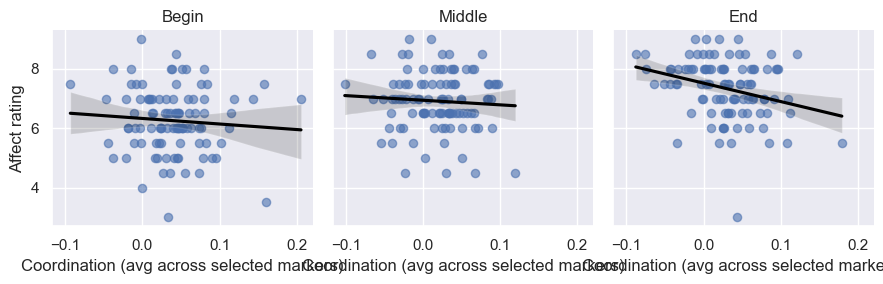

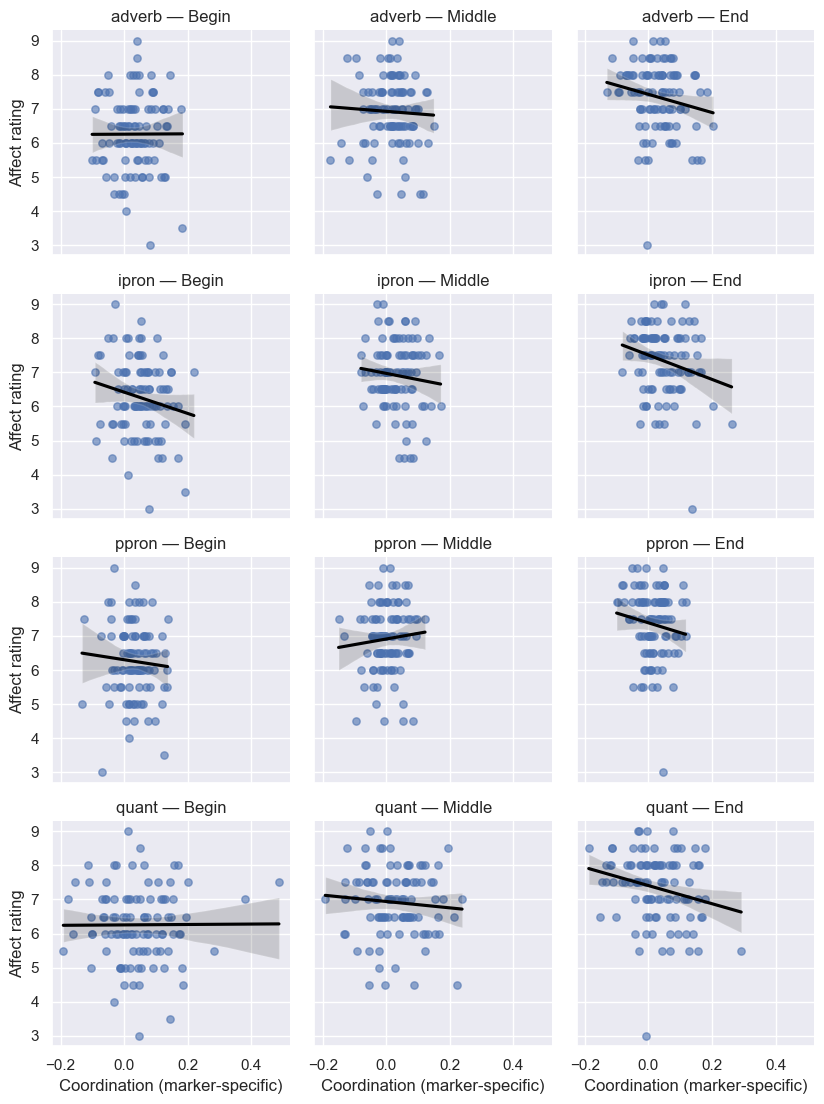

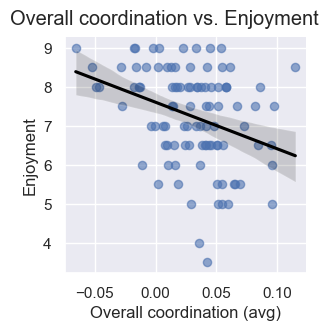

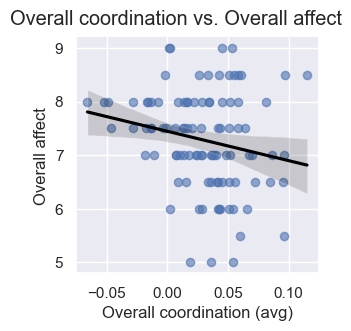

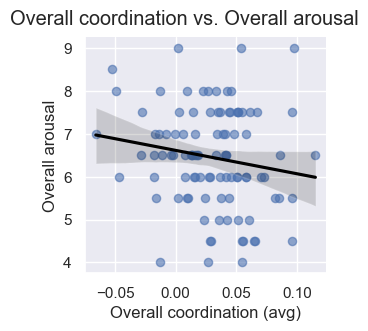

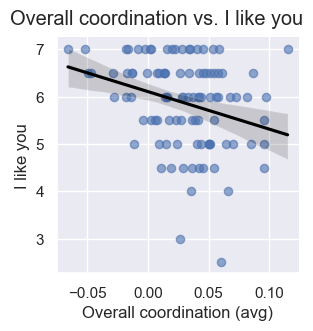

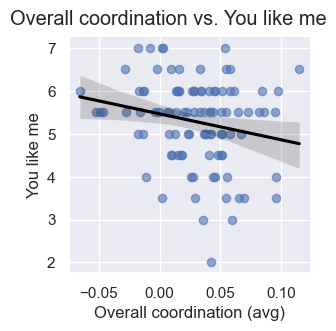

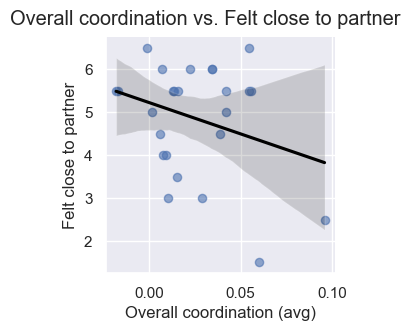

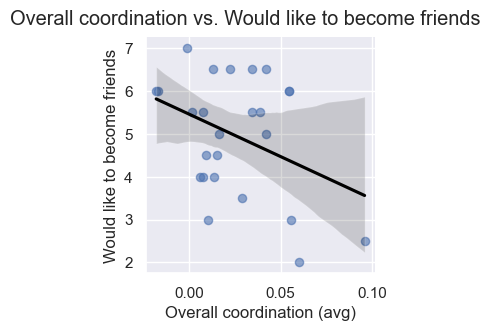

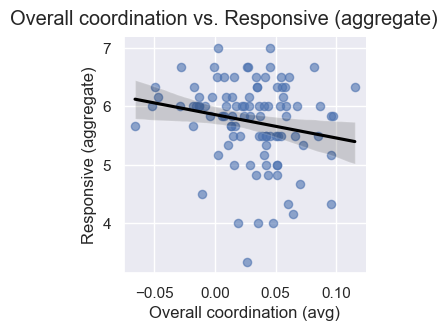

In [44]:
segment_affect_map = {
    'begin': 'begin_affect',
    'middle': 'middle_affect',
    'end': 'end_affect',
}

segment_frames = []
for segment, affect_col in segment_affect_map.items():
    coord_col = f'{segment}_avg_coord'
    if coord_col not in analysis_df.columns or affect_col not in analysis_df.columns:
        continue
    temp = analysis_df[['conversation_id', coord_col, affect_col]].dropna()
    if temp.empty:
        continue
    temp = temp.rename(columns={coord_col: 'coordination', affect_col: 'affect'})
    temp['segment'] = segment.capitalize()
    segment_frames.append(temp)

if segment_frames:
    segment_long = pd.concat(segment_frames, ignore_index=True)
    g = sns.lmplot(
        data=segment_long,
        x='coordination',
        y='affect',
        col='segment',
        col_wrap=3,
        height=3,
        scatter_kws={'alpha': 0.6, 's': 35},
        line_kws={'color': 'black'},
    )
    g.set_titles('{col_name}')
    g.set_axis_labels('Coordination (avg across selected markers)', 'Affect rating')
    plt.tight_layout()
else:
    print('No segment-level data to plot; check coordination or affect availability.')

markers_for_plot = sorted(MARKERS_OF_INTEREST)
marker_segment_frames = []
for segment, affect_col in segment_affect_map.items():
    for marker in markers_for_plot:
        coord_col = f'{segment}_{marker}_coord'
        if coord_col not in analysis_df.columns or affect_col not in analysis_df.columns:
            continue
        temp = analysis_df[['conversation_id', coord_col, affect_col]].dropna()
        if temp.empty:
            continue
        temp = temp.rename(columns={coord_col: 'coordination', affect_col: 'affect'})
        temp['segment'] = segment.capitalize()
        temp['marker'] = marker
        marker_segment_frames.append(temp)

if marker_segment_frames:
    marker_long = pd.concat(marker_segment_frames, ignore_index=True)
    g_marker = sns.lmplot(
        data=marker_long,
        x='coordination',
        y='affect',
        col='segment',
        row='marker',
        height=2.8,
        scatter_kws={'alpha': 0.6, 's': 28},
        line_kws={'color': 'black'},
    )
    g_marker.set_axis_labels('Coordination (marker-specific)', 'Affect rating')
    g_marker.set_titles('{row_name} — {col_name}')
    plt.tight_layout()
else:
    print('No marker-specific data to plot.')

overall_outcomes = {
    'how_enjoyable': 'Enjoyment',
    'overall_affect': 'Overall affect',
    'overall_arousal': 'Overall arousal',
    'i_like_you': 'I like you',
    'you_like_me': 'You like me',
    'i_felt_close_to_my_partner': 'Felt close to partner',
    'i_would_like_to_become_friends': 'Would like to become friends',
    'responsive': 'Responsive (aggregate)',
}

if 'overall_avg_coord' in analysis_df.columns:
    for outcome, label in overall_outcomes.items():
        if outcome not in analysis_df.columns:
            continue
        data = analysis_df[['overall_avg_coord', outcome]].dropna()
        if data.empty:
            continue
        g_out = sns.lmplot(
            data=data,
            x='overall_avg_coord',
            y=outcome,
            height=3.2,
            scatter_kws={'alpha': 0.6, 's': 35},
            line_kws={'color': 'black'},
        )
        g_out.set_axis_labels('Overall coordination (avg)', label)
        g_out.fig.suptitle(f'Overall coordination vs. {label}', y=1.03)
else:
    print('overall_avg_coord not found in analysis_df columns.')

## Next Steps
- Validate the begin / middle / end segmentation (e.g., by turn count or equal-duration windows).
- Explore additional quality outcomes such as `overall_affect` or closeness ratings.
- Consider mixed-effects or regression models to control for speaker-level variance once feasibility is confirmed.
- Capture decisions about preprocessing and feature engineering for the final report.

In [45]:
overall_outcome_cols = [
    'how_enjoyable',
    'affect',
    'overall_affect',
    'overall_arousal',
    'i_like_you',
    'you_like_me',
    'i_felt_close_to_my_partner',
    'i_would_like_to_become_friends',
    'responsive',
]

summary_rows = []
for outcome in overall_outcome_cols:
    if outcome not in analysis_df.columns or 'overall_avg_coord' not in analysis_df.columns:
        continue
    subset = analysis_df[['overall_avg_coord', outcome]].dropna()
    if subset.empty:
        continue
    pearson = subset['overall_avg_coord'].corr(subset[outcome])
    spearman = subset['overall_avg_coord'].corr(subset[outcome], method='spearman')
    summary_rows.append({
        'outcome': outcome,
        'n_pairs': len(subset),
        'pearson_r': pearson,
        'spearman_r': spearman,
    })

if summary_rows:
    overall_coord_summary = pd.DataFrame(summary_rows).sort_values('pearson_r', ascending=False)
    display(overall_coord_summary)
else:
    print('No overlapping data to summarize overall coordination correlations.')

,outcome,n_pairs,pearson_r,spearman_r
3,overall_arousal,99,-0.162800,-0.159845
1,affect,99,-0.190803,-0.153776
8,responsive,99,-0.194829,-0.212592
2,overall_affect,99,-0.204501,-0.202474
5,you_like_me,99,-0.209194,-0.200299
4,i_like_you,99,-0.290136,-0.296400
6,i_felt_close_to_my_partner,25,-0.293364,-0.121568
0,how_enjoyable,99,-0.332933,-0.338752
7,i_would_like_to_become_friends,25,-0.372387,-0.247537
